# Malaria Classification Assignment Overview

## Introduction

This assignment focuses on the development of a deep learning model for the classification of malaria cell images.

## Objective

The goal of this assignment is to create a model capable of distinguishing between two key classes:

- **Uninfected Cells:** Healthy red blood cells without malaria infection.
- **Parasitized Cells:** Red blood cells infected with Plasmodium parasites.

## Dataset

The dataset comprises a collection of images depicting both uninfected and parasitized cells. Sourced from the official NIH Malaria Datasets, it contains a total of `27,558` images.

## Methodology

This Assignment will leverage deep learning techniques, specifically Convolutional Neural Networks (CNNs), to train a model that can automatically learn and differentiate between features associated with infected and uninfected cells. The model will be trained on a labeled dataset and evaluated on a separate test set to assess its classification performance.

## Acknowledgements
- [Malaria Cell Images Dataset](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria/data)

# Import important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.applications.vgg19 import VGG19
import seaborn as sns

In [4]:
import pathlib
path = "C:/Users/Asus/Documents/internship/IQ Gateway/cell_images"
data_dir = pathlib.Path(path).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [6]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of uninfected cells", len(parasitized))

Number of uninfected cells 13780
Number of uninfected cells 13780


# Displaying some examples

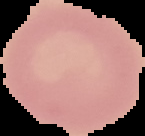

In [7]:
PIL.Image.open(uninfected[1])

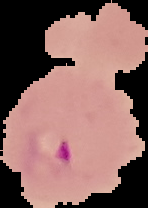

In [8]:
PIL.Image.open(parasitized[1])

In [9]:
batch_size = 32
img_height = 150
img_width = 150

In [10]:
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [11]:
training_data = image_gen.flow_from_directory(
    data_dir,
    subset = "training",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    subset = "validation",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 38583 images belonging to 3 classes.
Found 16533 images belonging to 3 classes.


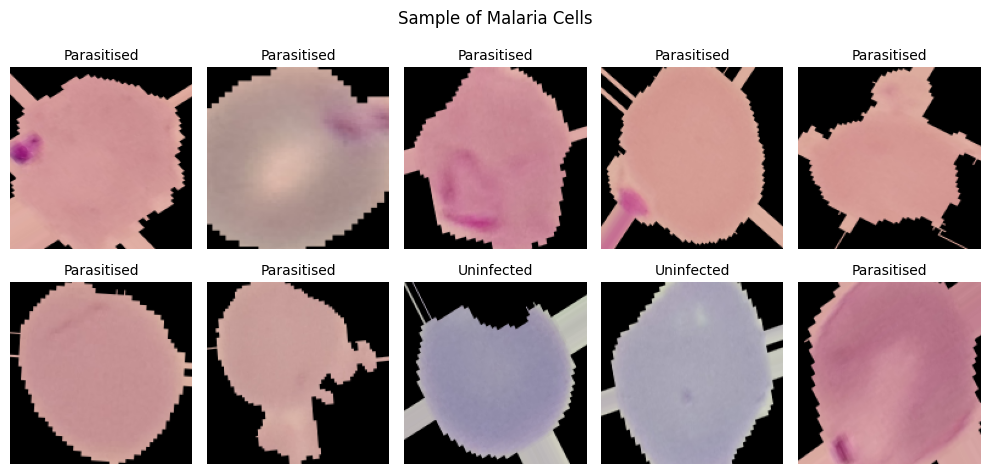

In [12]:
X_train, y_train = next(training_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i])
    ax.axis("off")
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()

# Building 'Home-Made' Network

## Our model Architecture

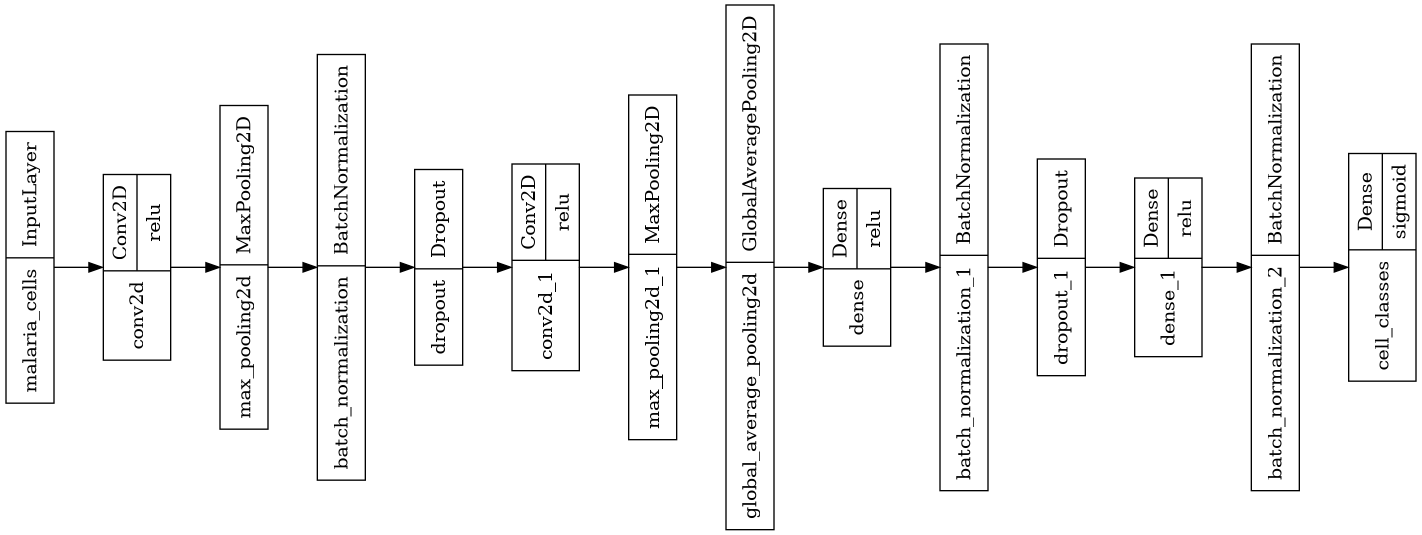

In [13]:
input = Input(shape = (img_width, img_height, 3), dtype=tf.float32, name="malaria_cells")
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(input)
X = MaxPooling2D(pool_size = (2, 2))(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(X)
X = MaxPooling2D(pool_size = (2, 2))(X)

X = GlobalAveragePooling2D()(X)
X = Dense(512, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model = Model(inputs=input, outputs=output)

In [14]:
plot_model(model, "model.png", show_layer_activations=True)
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 malaria_cells (InputLayer)  [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 75, 75, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 75, 75, 

In [15]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

## Training our model

In [17]:
epochs = 5

checkpoint_filepath = 'C:/Users/Asus/Documents/internship/IQ Gateway/Checkpath'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3, restore_best_weights=True)

history = model.fit(training_data, epochs=epochs, validation_data=validation_data, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/5
1206/1206 [==============================] - 1201s 995ms/step - loss: -809.9933 - accuracy: 0.3420 - val_loss: 1.3841 - val_accuracy: 0.2494
Epoch 2/5
1206/1206 [==============================] - 1108s 919ms/step - loss: -2223.2549 - accuracy: 0.3435 - val_loss: -81.8040 - val_accuracy: 0.2584
Epoch 3/5
1206/1206 [==============================] - 1172s 971ms/step - loss: -4087.6609 - accuracy: 0.3443 - val_loss: 1008.4345 - val_accuracy: 0.2530
Epoch 4/5
1206/1206 [==============================] - 1368s 1s/step - loss: -6414.1733 - accuracy: 0.3448 - val_loss: -178.2381 - val_accuracy: 0.2494
Epoch 5/5
1206/1206 [==============================] - 1255s 1s/step - loss: -9111.3359 - accuracy: 0.3415 - val_loss: 448.0164 - val_accuracy: 0.2502


In [18]:
model.save("malaria-cnn-v1.keras")

In [19]:
model.evaluate(validation_data)

517/517 [==============================] - 156s 302ms/step - loss: 473.0472 - accuracy: 0.2502


[473.0472106933594, 0.25022682547569275]

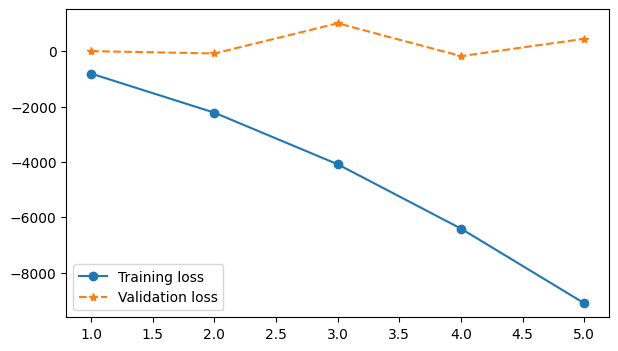

In [20]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

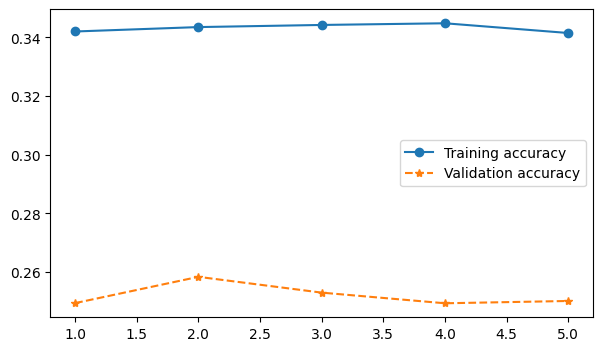

In [22]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

In [23]:
y_pred_proba = model.predict(validation_data).flatten()
y_pred_classes = (y_pred_proba >= 0.5).astype(np.int32)

517/517 [==============================] - 390s 754ms/step


In [24]:
def evaluate_ramdom_image(path, ax):
    image = load_img(str(path), target_size=(img_width, img_height))
    img_arr = img_to_array(image)
    img_arr /= 255
    pred = model.predict(img_arr.reshape(1, *img_arr.shape), verbose=0).flatten()
    label = "Parasitised" if pred < 0.5 else "Uninfected"
    ax.imshow(img_arr, vmin=1, vmax=1)
    ax.set_title(f"{label} - {pred[0]:.2%}", size=10)
    ax.axis("off")
    # plt.show()

In [25]:
parasitized_path = list(data_dir.glob("Parasitized/*"))
uninfected_path = list(data_dir.glob("Uninfected/*"))

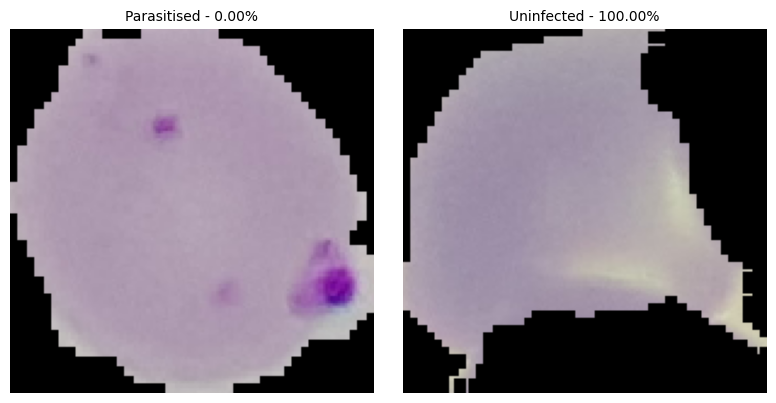

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
index = np.random.randint(len(parasitized_path))
evaluate_ramdom_image(parasitized_path[index], ax1)
evaluate_ramdom_image(uninfected_path[index], ax2)
plt.tight_layout()

In [31]:
import tensorflow as tf

def load_model():
    return tf.keras.models.load_model("malaria-cnn-v1.keras")


In [32]:
def preprocess_image(image):
    img = image.resize((img_width, img_height))
    img = img_to_array(img) / 255.0
    img = img.reshape((1,) + img.shape)
    return img


In [33]:
def predict(image):
    model = load_model()
    preprocessed_img = preprocess_image(image)
    prediction = model.predict(preprocessed_img)
    return prediction[0][0]


Thank You